# Covid-19 Death prediction

### 1. Data Cleaning

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.metrics import accuracy_score, classification_report,make_scorer, precision_score,roc_curve, roc_auc_score, auc, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [2]:
PatientAll = pd.read_csv("COVID19MEXICO2020.csv")

C:\Users\laven\AppData\Local\Temp\ipykernel_19536\419699222.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  PatientAll = pd.read_csv("COVID19MEXICO2020.csv")


In [3]:
filtered_df = PatientAll[PatientAll['CLASIFICACION_FINAL'] <= 3]
covidPatient = filtered_df.head(10000)
# covidPatient.to_csv('filtered_dataset.csv', index=False)

In [4]:
covidPatient.head(6)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-10-31,z4d6fe,1,6,24,1,24,24,28,1,...,2,1,1,2,97,3,99,México,97,97
3,2021-10-31,z3bf80,2,12,8,2,8,8,37,1,...,2,1,1,2,97,3,99,México,97,97
15,2021-10-31,z54912,1,12,31,1,31,31,79,1,...,2,1,1,2,97,3,99,México,97,97
18,2021-10-31,z552ac,1,12,1,1,9,1,1,1,...,2,1,1,2,97,3,99,México,97,97
20,2021-10-31,z59345,1,12,31,2,31,31,89,1,...,2,1,1,2,97,3,99,México,97,97
23,2021-10-31,z4887b,2,12,8,1,10,8,37,1,...,1,1,1,2,97,3,99,México,97,97


In [5]:
U_mexicoPatient = covidPatient

In [6]:
U_mexicoPatient.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

In [7]:
## translation the column from spanish to English
U_mexicoPatient.columns = ['UPDATE_DATE', 'RECORD_ID', 'ORIGIN', 'MEDICAL_UNIT', 'ENTITY_UM',
       'SEX', 'ENTITY_NAC', 'ENTITY_RES', 'MUNICIPALITY_RES', 'PATIENT_TYPE',
       'ADMISSION_DATE', 'SYMPTOM_DATE', 'DATE_DIED', 'INTUBATED', 'PNEUMONIA',
       'AGE', 'NATIONALITY', 'PREGNANCY', 'INDIGENOUS_LANGUAGE_SPEAKER', 'INDIGENOUS',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_COM',
       'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'SMOKING',
       'OTHER_CASE', 'LAB_SAMPLE_TAKING', 'LAB_RESULT',
       'ANTIGEN_SAMPLE_TAKE', 'ANTIGEN_RESULT', 'CLASSIFICATION',
       'MIGRANT', 'COUNTRY_NATIONALITY', 'COUNTRY_OF_ORIGIN', 'ICU']

In [8]:
## select the useful columns
mexicoPatient = U_mexicoPatient[["SEX", "AGE", "CLASSIFICATION", "PATIENT_TYPE", "PNEUMONIA", "PREGNANCY", "DIABETES", 'COPD', 'ASTHMA', "INMSUPR" ,"HYPERTENSION", "CARDIOVASCULAR", "RENAL_CHRONIC", "OTHER_COM", "OBESITY", "SMOKING", "ORIGIN", "MEDICAL_UNIT", "INTUBATED", "ICU", "DATE_DIED"]]

In [9]:
## replace all the missing value that indicate using numbers 97,98,99 to nan
mexicoPatient= mexicoPatient.replace(97, np.nan)
mexicoPatient= mexicoPatient.replace(98, np.nan)
mexicoPatient= mexicoPatient.replace(99, np.nan)
mexicoPatient["AGE"] = covidPatient["AGE"]

In [10]:
columns_to_replace = mexicoPatient.columns.difference(['AGE', 'CLASSIFICATION', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'DATE_DIED', 'SEX','ORIGIN'])
mexicoPatient[columns_to_replace] = mexicoPatient[columns_to_replace].replace({1: 'Y', 2: 'N'})
mexicoPatient['PATIENT_TYPE'] = mexicoPatient['PATIENT_TYPE'].replace({1: 'home', 2: 'hospital'})
mexicoPatient['SEX'] = mexicoPatient['SEX'].replace({1: 'F', 2: 'M'})

In [11]:
age_bins = [0, 30, 40, 50, 60, 100]  
age_labels = ['0-30', '31-40', '41-50', '51-60', '61+']

# Create a new column based on the binning
mexicoPatient['AGE'] = pd.cut(mexicoPatient['AGE'], bins=age_bins, labels=age_labels, right=False)

In [12]:
## change the Data of Died to a Catogoty variable Died
mexicoPatient['DATE_DIED'] = mexicoPatient['DATE_DIED'].apply(lambda x: 'alive' if x == '9999-99-99' else "died")
mexicoPatient.rename(columns = {"DATE_DIED": "STATUS"}, inplace=True)

In [13]:
mexicoPatient.head(6)

,SEX,AGE,CLASSIFICATION,PATIENT_TYPE,PNEUMONIA,PREGNANCY,DIABETES,COPD,ASTHMA,INMSUPR,...,CARDIOVASCULAR,RENAL_CHRONIC,OTHER_COM,OBESITY,SMOKING,ORIGIN,MEDICAL_UNIT,INTUBATED,ICU,STATUS
0,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,6,NaN,NaN,alive
3,M,31-40,3,home,N,NaN,N,N,N,N,...,N,N,N,N,N,2,12,NaN,NaN,alive
15,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
18,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
20,M,31-40,3,home,N,NaN,N,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
23,F,61+,3,home,N,N,N,N,N,N,...,N,N,N,N,N,2,12,NaN,NaN,alive


In [14]:
mexicoPatient.shape[1]

21

In [15]:
#Death rate
mexicoPatient["STATUS"].value_counts().get('died',0)/10000

0.1841

C:\Users\laven\AppData\Local\Temp\ipykernel_19536\3672117033.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


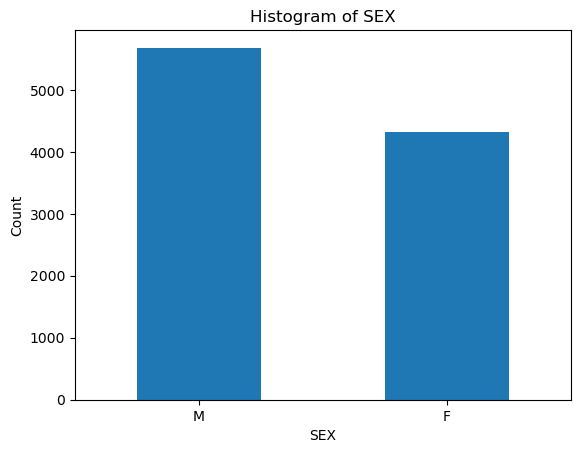

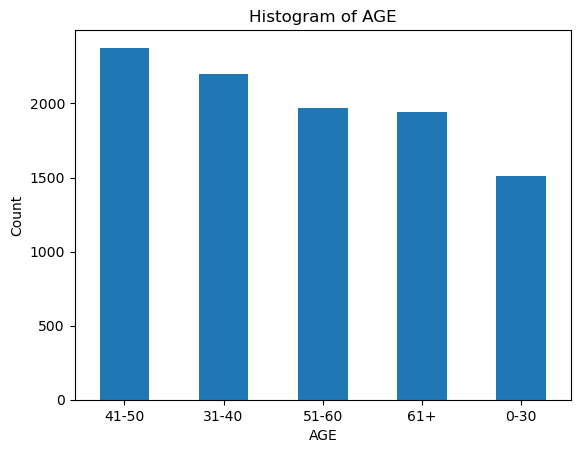

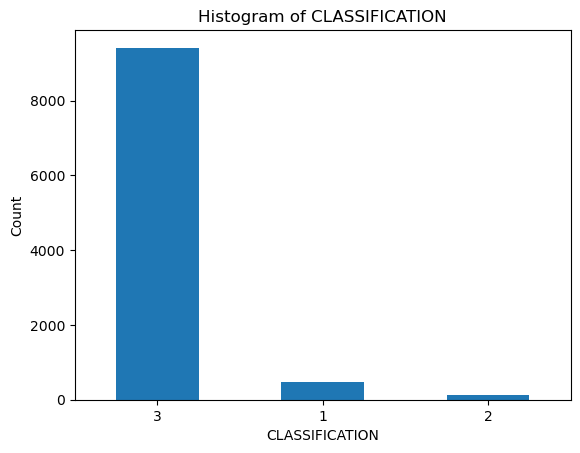

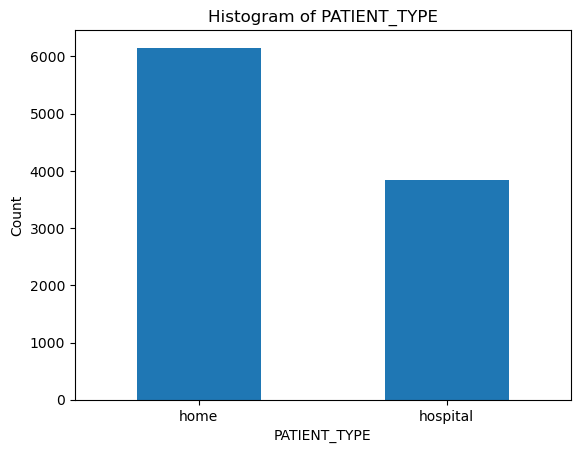

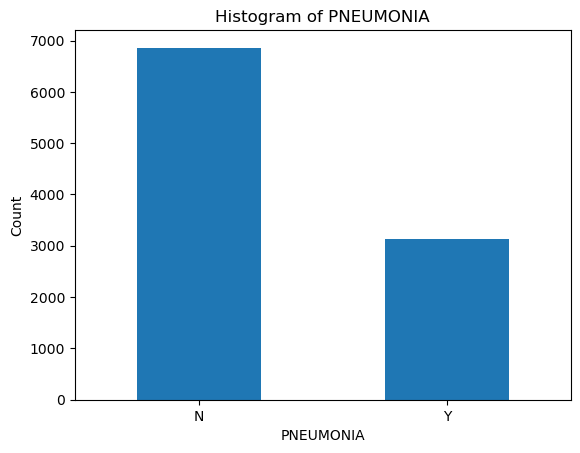

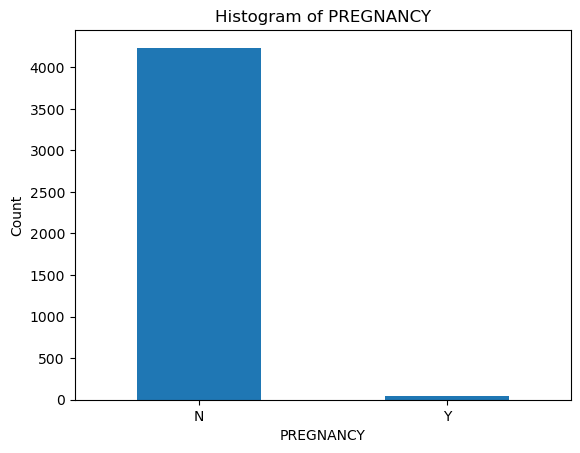

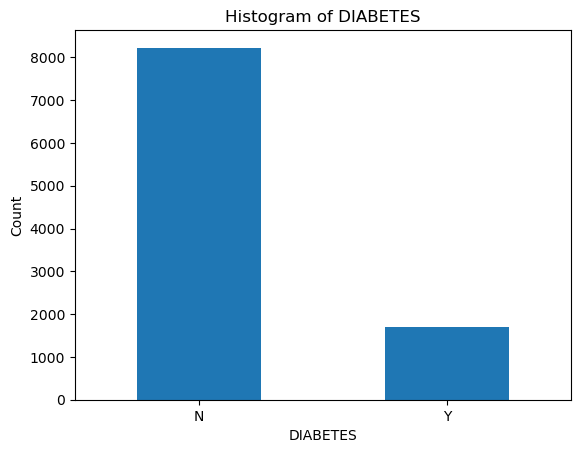

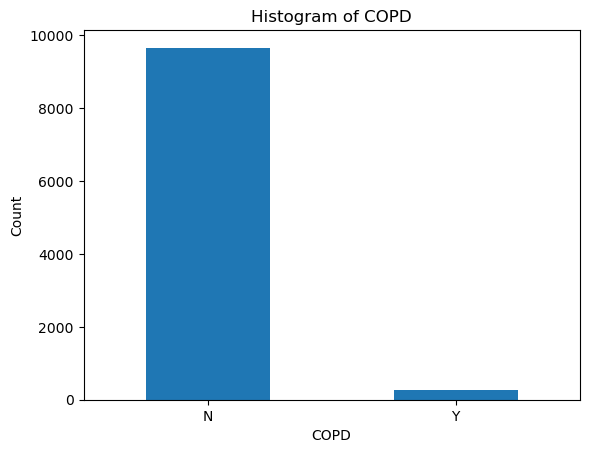

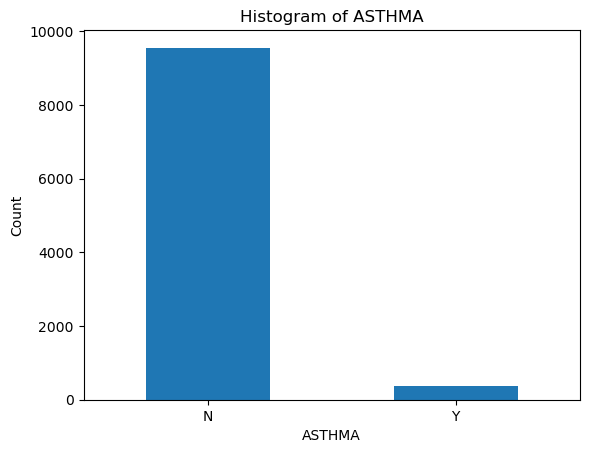

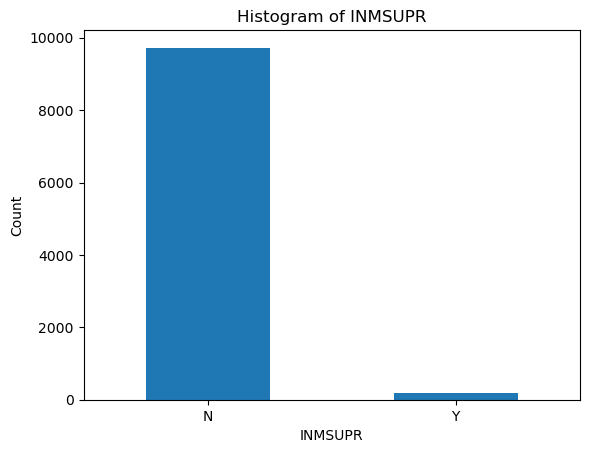

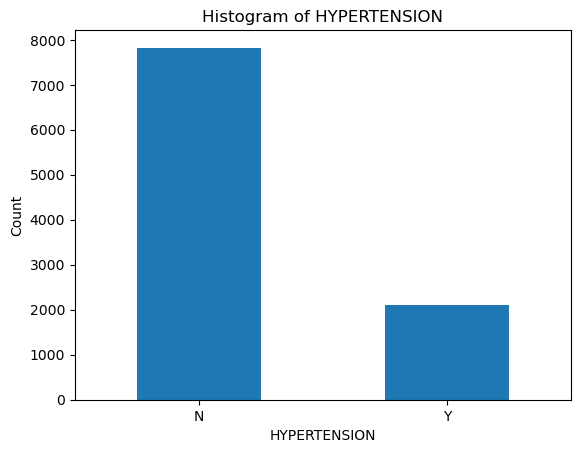

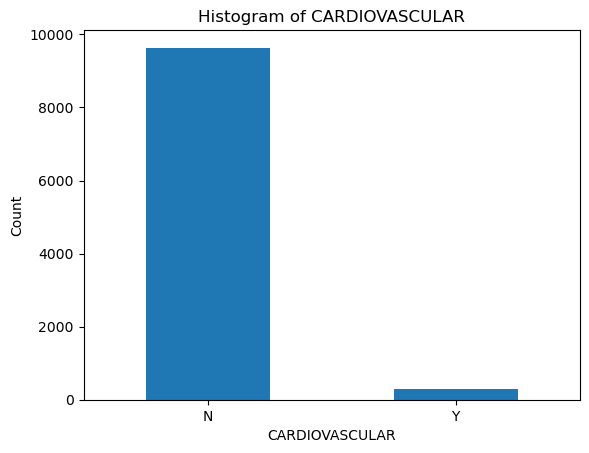

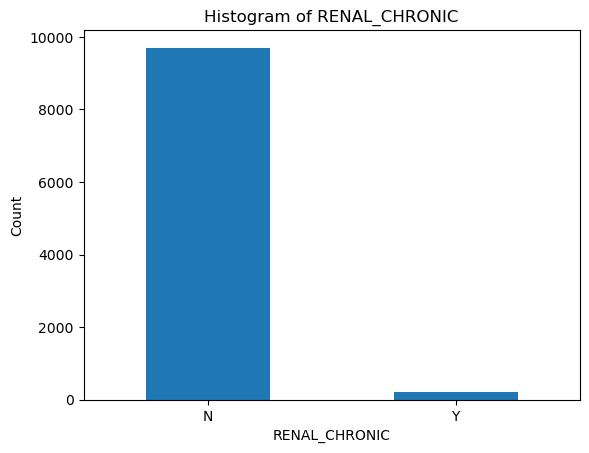

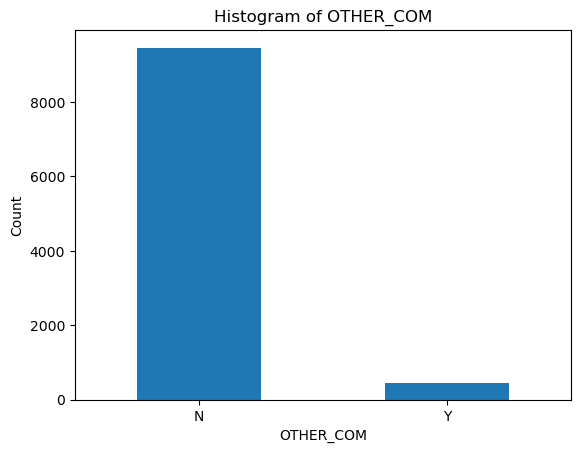

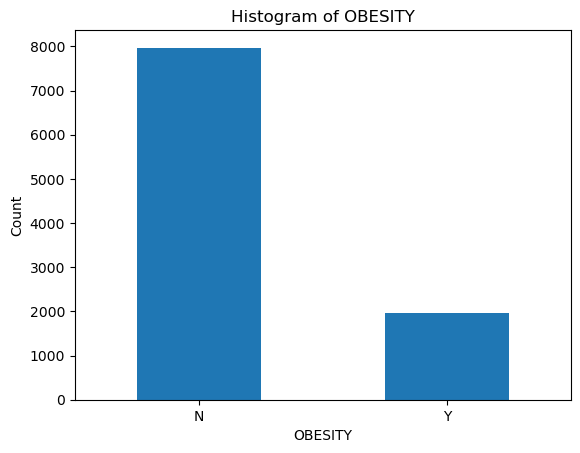

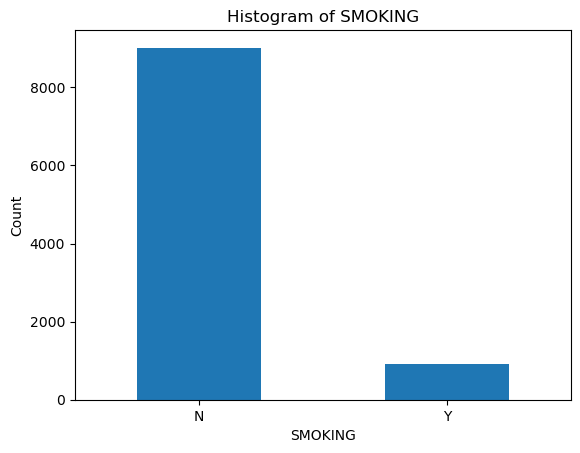

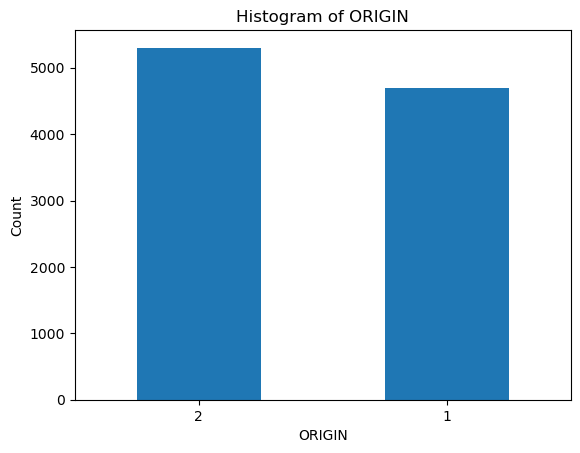

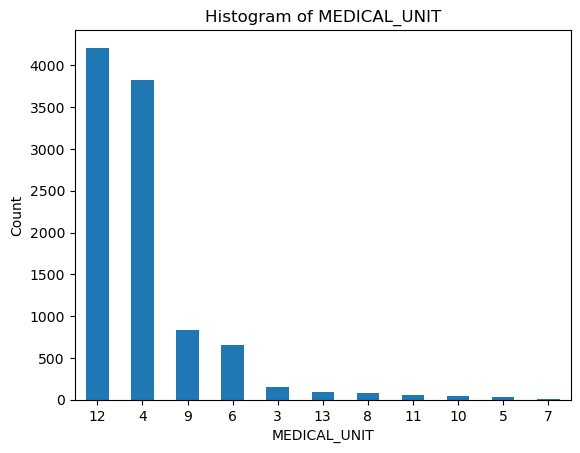

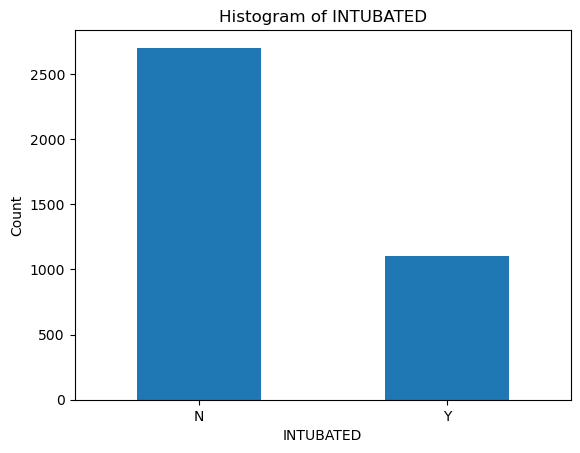

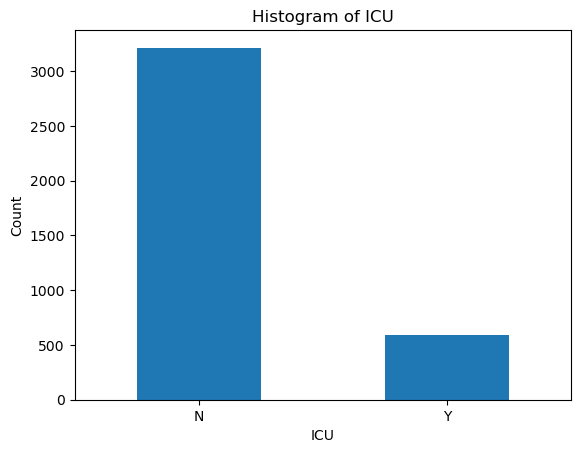

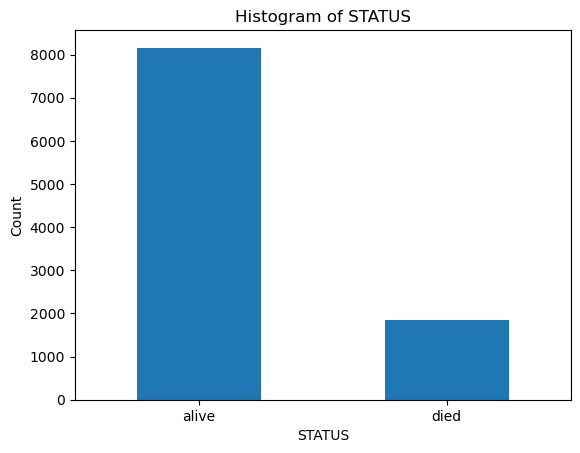

In [16]:
for column in mexicoPatient.columns:
    plt.figure()
    counts = mexicoPatient[column].value_counts()
    counts.plot(kind='bar', rot=0)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Histogram of {column}')

plt.show()

### About Dataset
The dataset was provided by the Mexican government (https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 40 unique features and 4 million unique patients. Since we are focusing on COVID-19 patients, we have filtered the individuals diagnosed with COVID-19, specifically those with a classification value less than or equal to 3. After cleaning, the dataset contains 21 unique features and 10,000 unique patient records. (We have removed certain variables such as ID, Country, and Language. The information for the remaining 21 features is listed below.

- sex: female / male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 'home' for returned home and 'hospital' for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease (OTHER_COM): whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- smoking: whether the patient is a tobacco user.
- origin: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- status: whether the patient died in 2020.

In [17]:
# mexicoPatient_train, mexicoPatient_test = train_test_split(mexicoPatient, test_size=0.3, random_state=88)

#baseline
default_false = np.sum(mexicoPatient['STATUS'] == 'alive')  # alive
default_true = np.sum(mexicoPatient['STATUS'] == 'died')   # died
print(pd.Series({'0': default_false, '1': default_true}))

0    8159
1    1841
dtype: int64


In [18]:
accuracy_base = default_false/(default_false + default_true)
accuracy_base

0.8159

In [19]:

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn+tp)
    tpr = tp / (tp+fn)
    precision = tp/(tp+fp)
    print("Accuracy:", acc)
    print("True Positive Rate (Recall):", tpr)
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)
    print("Precision:", precision)

    # Return the metrics
    return acc, tpr, fpr, fnr, precision

In [20]:
# Possible model: logistic, CART, R.F(with cv), Decision Tree, LASSO

In [21]:
# Logistic


# Separating the features and the target variable
X = mexicoPatient.drop('STATUS', axis=1)
y = mexicoPatient['STATUS']

# Identifying categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Creating a column transformer for one-hot encoding
column_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Transforming the data
X_transformed = column_transformer.fit_transform(X)

# Splitting set
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((8000, 55), (8000,))

In [22]:
# By default Logistic Regression model use L2 regularization, which can shrink the less important coefficient but not set them to zero
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_log = logistic_model.predict(X_test)

accuracy_log = accuracy_score(y_test, y_pred_log)
classification_rep = classification_report(y_test, y_pred_log)

print(accuracy_log)

0.903


**Recall**: Same as sensitivity, measures the proportion of actual positive cases that were correctly identified by the model. For a class, it is calculated as the number of true positive predictions divided by the sum of true positive and false negative predictions.

**F1-Score**: The F1-score is a measure of a model's accuracy that considers both precision and recall. Precision is the proportion of positive identifications that were actually correct, while recall, as mentioned above, is the proportion of actual positive cases that were identified correctly. 

**Support***: This number refers to the actual number of occurrences of the class in the specified dataset. For instance, if the 'alive' class has a support of 1000, it means there were 1000 actual instances of 'alive' in the dataset. It's useful for understanding the scale of the prediction task for each class and can also provide insight into the dataset's balance or imbalance.

In [23]:
# Confusion Matrix

y_pred = logistic_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# [[true_negative, false_positive]
#  [false_negative, true_positive]]

[[1598   71]
 [ 123  208]]


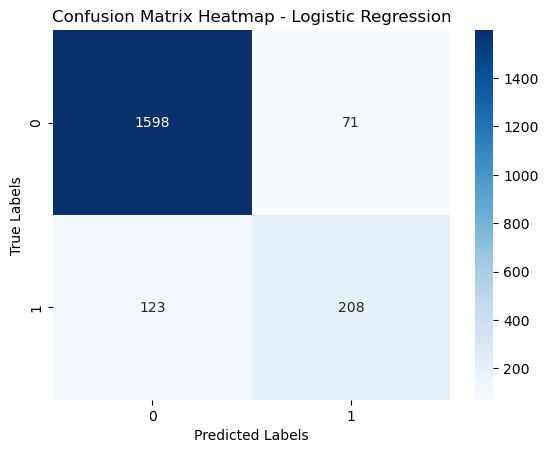

In [24]:
conf_matrix_logistic = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_logistic, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap - Logistic Regression')
plt.show()

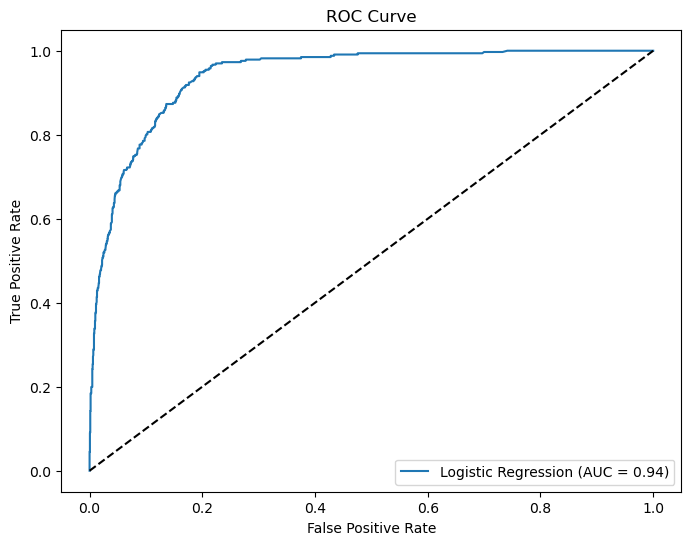

In [25]:
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic, pos_label='died')
auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## LR result

In [26]:
Logistic_result = evaluate_model(y_test, y_pred)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.903
True Positive Rate (Recall): 0.6283987915407855
False Positive Rate (FPR): 0.04254044337926902
False Negative Rate (FNR): 0.3716012084592145
Precision: 0.7455197132616488


In [27]:
# Decision Tree

decision_tree_model = DecisionTreeClassifier(random_state=42,min_samples_leaf=6,max_leaf_nodes=6, class_weight = {'alive':1, 'died':4})
decision_tree_model.fit(X_train, y_train)

y_pred_dt = decision_tree_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print(accuracy_dt)

0.8455


In [28]:
DecisionTree_result = evaluate_model(y_test, y_pred_dt)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.8455
True Positive Rate (Recall): 0.8489425981873112
False Positive Rate (FPR): 0.15518274415817854
False Negative Rate (FNR): 0.1510574018126888
Precision: 0.5203703703703704


In [29]:
# DT (with CV)

param_grid_decision_tree = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight':[{'alive':1, 'died':4}]
}

grid_search_decision_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                                         param_grid=param_grid_decision_tree, 
                                         scoring='accuracy',
                                         cv=5)

grid_search_decision_tree.fit(X_transformed, y)
best_params_decision_tree = grid_search_decision_tree.best_params_
best_score_decision_tree = grid_search_decision_tree.best_score_

print(best_params_decision_tree)
print(best_score_decision_tree)

{'class_weight': {'alive': 1, 'died': 4}, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.8586


In [30]:
best_params_decision_tree = grid_search_decision_tree.best_params_
optimized_decision_tree = DecisionTreeClassifier(**best_params_decision_tree)
optimized_decision_tree.fit(X_train, y_train)
y_pred_optimized = optimized_decision_tree.predict(X_test)
accuracy_dt_cv = accuracy_score(y_test, y_pred_optimized)
print(accuracy_dt_cv)

0.853


In [31]:
DecisionTreeCv_result = evaluate_model(y_test, y_pred_optimized)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.853
True Positive Rate (Recall): 0.8972809667673716
False Positive Rate (FPR): 0.15578190533253444
False Negative Rate (FNR): 0.1027190332326284
Precision: 0.533213644524237


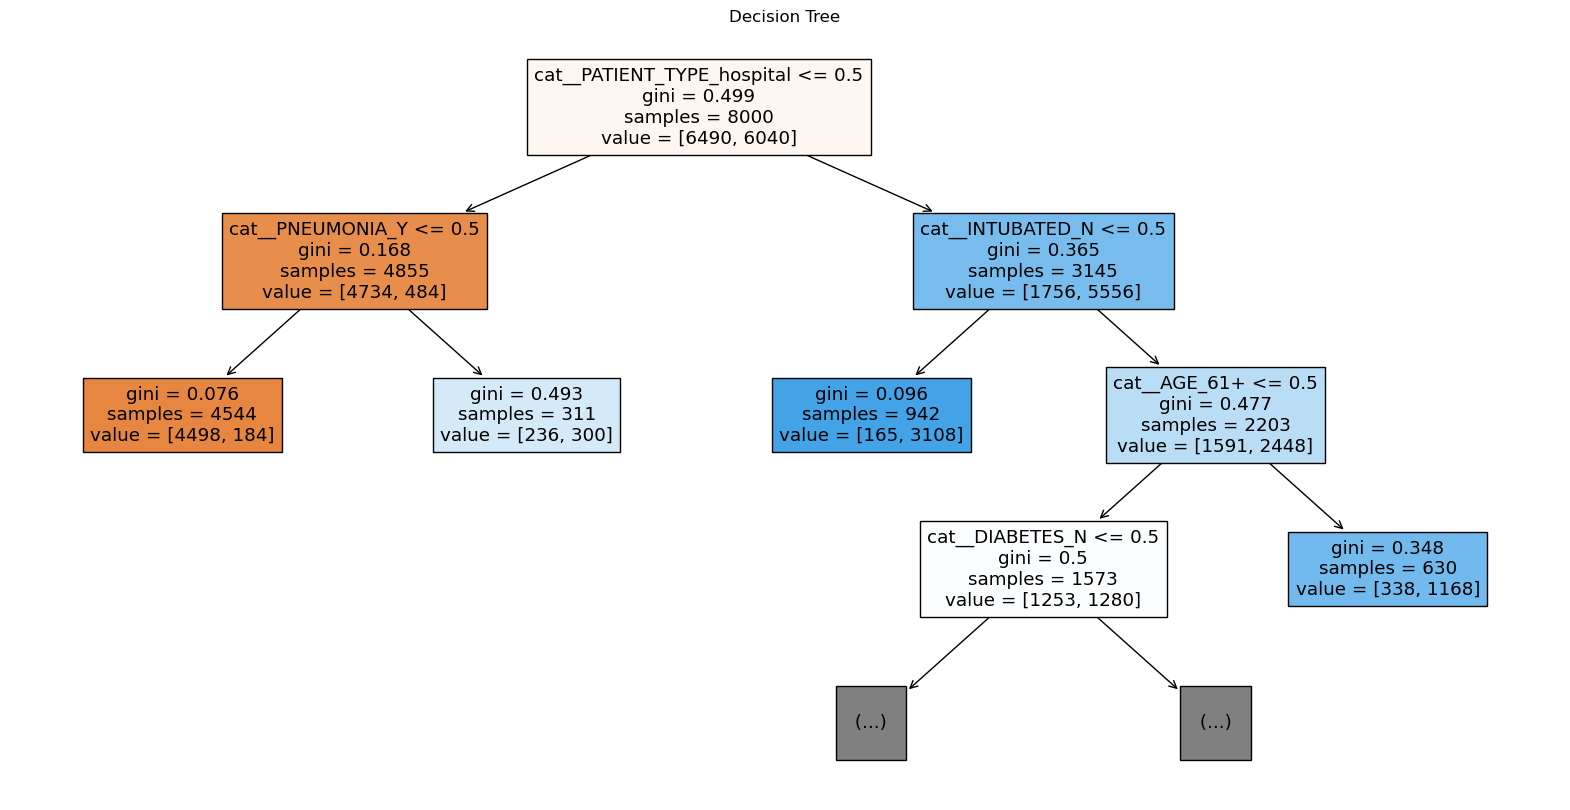

In [32]:
transformed_feature_names_array = column_transformer.get_feature_names_out()
transformed_feature_names_list = transformed_feature_names_array.tolist()

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=transformed_feature_names_list, max_depth=3)
plt.title('Decision Tree')
plt.show()

In [33]:
# LASSO

# Encoding the target variable for LASSO
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting set
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_transformed, y_encoded, test_size=0.2, random_state=42)

# Creating and fitting the LASSO model
# Note: We set a small alpha value to start, as LASSO can shrink coefficients to zero if alpha is too high
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_lasso, y_train_lasso)

y_pred_lasso = lasso_model.predict(X_test_lasso)

# Converting probabilities to class labels based on a 0.5 threshold
y_pred_lasso_class = [1 if prob > 0.5 else 0 for prob in y_pred_lasso]

accuracy_lasso = accuracy_score(y_test_lasso, y_pred_lasso_class)
classification_rep_lasso = classification_report(y_test_lasso, y_pred_lasso_class)

print(accuracy_lasso)

0.8995


In [34]:
lasso_result = evaluate_model(y_test_lasso, y_pred_lasso_class)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.8995
True Positive Rate (Recall): 0.48942598187311176
False Positive Rate (FPR): 0.019173157579388856
False Negative Rate (FNR): 0.5105740181268882
Precision: 0.8350515463917526


In [35]:
# Random Forest Classifier

random_forest_model = RandomForestClassifier(random_state=42,min_samples_leaf=6,max_leaf_nodes=6,  class_weight={'alive':1, 'died':4})
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(accuracy_rf)

0.801


In [36]:
RandomForest_result = evaluate_model(y_test, y_pred_rf)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.801
True Positive Rate (Recall): 0.918429003021148
False Positive Rate (FPR): 0.22228879568603954
False Negative Rate (FNR): 0.08157099697885196
Precision: 0.45037037037037037


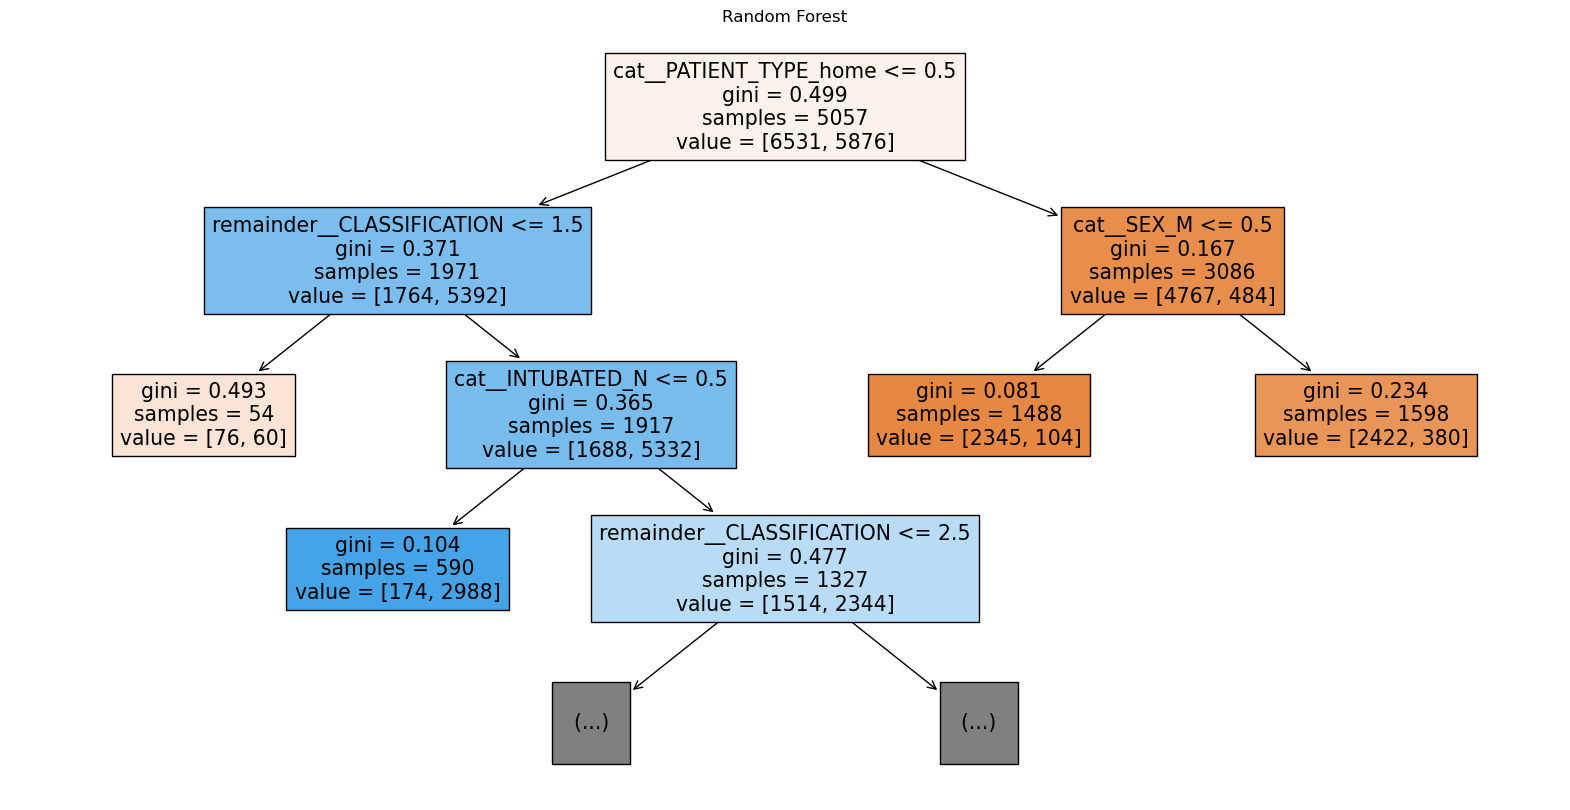

In [37]:
tree_in_forest = random_forest_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree_in_forest, filled=True, feature_names=transformed_feature_names_list, max_depth=3)
plt.title('Random Forest')
plt.show()

In [38]:
# Random Forest Classifier (with CV)

single_tree = DecisionTreeClassifier(random_state=42)
path = single_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

scores = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    score = cross_val_score(tree, X_train, y_train, cv=5)
    scores.append(np.mean(score))
    
best_ccp_alpha = ccp_alphas[np.argmax(scores)]

random_forest_model = RandomForestClassifier(random_state=42, ccp_alpha=best_ccp_alpha, class_weight={'alive':1, 'died':4})
random_forest_model.fit(X_train, y_train)

y_pred_rf_cv = random_forest_model.predict(X_test)

accuracy_rf_cv = accuracy_score(y_test, y_pred_rf_cv)
print(accuracy_rf_cv)

0.8665


In [39]:
RandomForestCv_result = evaluate_model(y_test, y_pred_rf_cv)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.8665
True Positive Rate (Recall): 0.8851963746223565
False Positive Rate (FPR): 0.1372079089275015
False Negative Rate (FNR): 0.1148036253776435
Precision: 0.5613026819923371


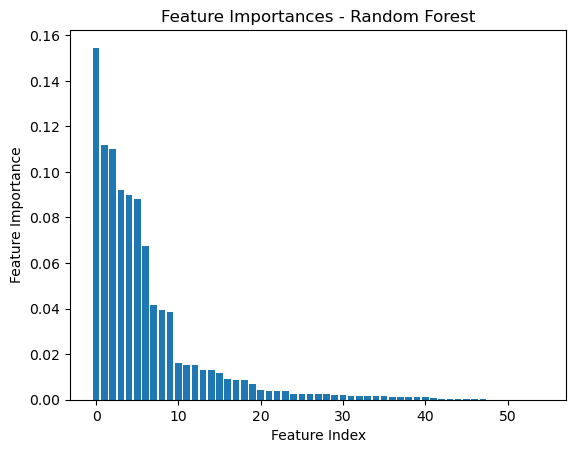

In [40]:
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(X_train.shape[1]), importances[indices])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances - Random Forest')
plt.show()

**Dominant Features**: The first few features (particularly the very first one) have significantly higher importance than the rest. This indicates that the model is heavily reliant on these features for making predictions.

**Declining Importance**: There is a sharp decline in feature importance after the first few features, suggesting that the model gains most of its predictive power from a small subset of features.

**Long Tail**: A long tail of features with low importance suggests that while these features do contribute to model decisions, their individual impact is relatively minor.

In [41]:
# 15 most important features (The importance of all features sums up to 1)
feature_names = column_transformer.get_feature_names_out()

importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[-15:]
importance_dict = dict(zip(feature_names, importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
top_15_features = sorted_importance[:15]

for feature, importance in top_15_features:
    print(f"{feature}: Importance: {importance:.4f}")

cat__PATIENT_TYPE_hospital: Importance: 0.1545
cat__PATIENT_TYPE_home: Importance: 0.1118
cat__ICU_nan: Importance: 0.1100
cat__PNEUMONIA_Y: Importance: 0.0922
cat__INTUBATED_nan: Importance: 0.0897
cat__INTUBATED_Y: Importance: 0.0880
cat__PNEUMONIA_N: Importance: 0.0677
cat__INTUBATED_N: Importance: 0.0416
cat__AGE_61+: Importance: 0.0394
cat__ICU_N: Importance: 0.0384
remainder__MEDICAL_UNIT: Importance: 0.0161
cat__DIABETES_N: Importance: 0.0154
cat__AGE_31-40: Importance: 0.0153
cat__DIABETES_Y: Importance: 0.0132
cat__HYPERTENSION_Y: Importance: 0.0131


In [42]:
len(sorted_importance)

55

SVMs are powerful for both classification and regression problems. In classification tasks, SVMs attempt to find the hyperplane that best separates the classes. SVMs are particularly useful when the classes are not linearly separable. They also work well with high-dimensional data and are effective when the number of dimensions is greater than the number of samples, which can be the case in complex medical datasets.

In [43]:
# Support Vector Machine (SVM)

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

print(accuracy_svm)

0.8995


In [44]:
SVM_result = evaluate_model(y_test, y_pred_svm)
# acc, tpr, fpr, fnr, precision

Accuracy: 0.8995
True Positive Rate (Recall): 0.48942598187311176
False Positive Rate (FPR): 0.019173157579388856
False Negative Rate (FNR): 0.5105740181268882
Precision: 0.8350515463917526


In [45]:
data = {
    'Model': ['Logistic', 'Decision Tree', 'Decision Tree (with CV)', 'LASSO','Random Forest Classifier','Random Forest (with CV)','SVM'],
    'Test Accuracy': [accuracy_log, accuracy_dt, accuracy_dt_cv, accuracy_lasso, accuracy_rf, accuracy_rf_cv, accuracy_svm]
}
performance = pd.DataFrame(data)
performance

,Model,Test Accuracy
0,Logistic,0.9030
1,Decision Tree,0.8455
2,Decision Tree (with CV),0.8530
3,LASSO,0.8995
4,Random Forest Classifier,0.8010
5,Random Forest (with CV),0.8665
6,SVM,0.8995


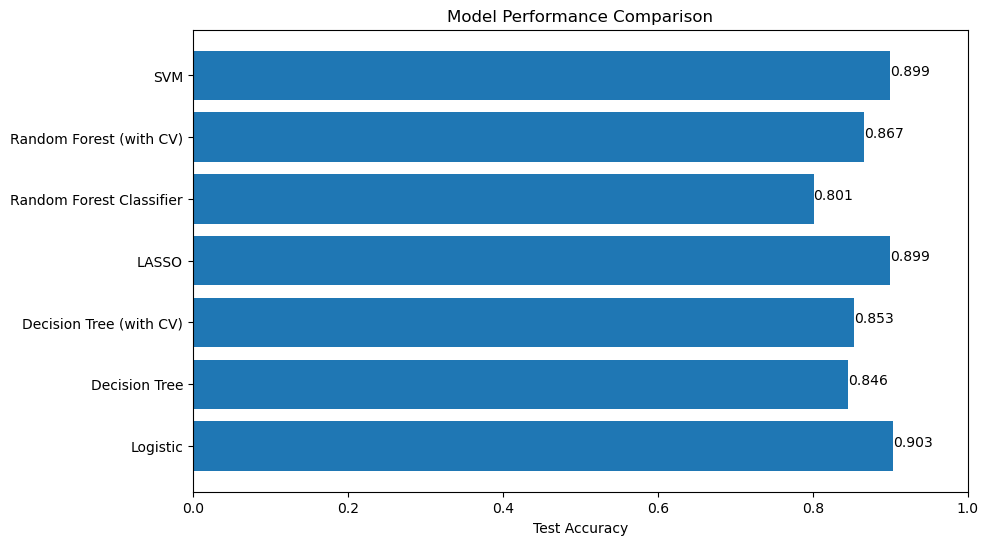

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(performance['Model'], performance['Test Accuracy'])
plt.xlabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.xlim(0, 1)
for index, value in enumerate(performance['Test Accuracy']):
    plt.text(value, index, f'{value:.3f}')
plt.show()

In [47]:
# check overfitting for RF and CART

# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate on Training Data
train_preds_rf = rf_model.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, train_preds_rf)

# Evaluate on Test Data
test_preds_rf = rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, test_preds_rf)

print(f"Random Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# CART (Decision Tree) Model
cart_model = DecisionTreeClassifier()
cart_model.fit(X_train, y_train)

# Evaluate on Training Data
train_preds_cart = cart_model.predict(X_train)
train_accuracy_cart = accuracy_score(y_train, train_preds_cart)

# Evaluate on Test Data
test_preds_cart = cart_model.predict(X_test)
test_accuracy_cart = accuracy_score(y_test, test_preds_cart)

print(f"CART - Training Accuracy: {train_accuracy_cart}")
print(f"CART - Test Accuracy: {test_accuracy_cart}")


Random Forest - Training Accuracy: 0.95775
Random Forest - Test Accuracy: 0.89
CART - Training Accuracy: 0.95775
CART - Test Accuracy: 0.8745


In [48]:
def print_results(model_name, result):
    acc, tpr, fpr, fnr, precision = result
    print(f"{model_name} Results:")
    print(f"  Accuracy: {acc}")
    print(f"  True Positive Rate (TPR): {tpr}")
    print(f"  False Positive Rate (FPR): {fpr}")
    print(f"  False Negative Rate (FNR): {fnr}")
    print(f"  Precision: {precision}")
    print()

# Print statements for each result
print_results("Logistic Regression", Logistic_result)
print_results("Decision Tree", DecisionTree_result)
print_results("Cross-validated Decision Tree", DecisionTreeCv_result)
print_results("Lasso", lasso_result)
print_results("Random Forest", RandomForest_result)
print_results("Cross-validated Random Forest", RandomForestCv_result)
print_results("SVM", SVM_result)

Logistic Regression Results:
  Accuracy: 0.903
  True Positive Rate (TPR): 0.6283987915407855
  False Positive Rate (FPR): 0.04254044337926902
  False Negative Rate (FNR): 0.3716012084592145
  Precision: 0.7455197132616488

Decision Tree Results:
  Accuracy: 0.8455
  True Positive Rate (TPR): 0.8489425981873112
  False Positive Rate (FPR): 0.15518274415817854
  False Negative Rate (FNR): 0.1510574018126888
  Precision: 0.5203703703703704

Cross-validated Decision Tree Results:
  Accuracy: 0.853
  True Positive Rate (TPR): 0.8972809667673716
  False Positive Rate (FPR): 0.15578190533253444
  False Negative Rate (FNR): 0.1027190332326284
  Precision: 0.533213644524237

Lasso Results:
  Accuracy: 0.8995
  True Positive Rate (TPR): 0.48942598187311176
  False Positive Rate (FPR): 0.019173157579388856
  False Negative Rate (FNR): 0.5105740181268882
  Precision: 0.8350515463917526

Random Forest Results:
  Accuracy: 0.801
  True Positive Rate (TPR): 0.918429003021148
  False Positive Rate (F